**Capstone Project: INFO6147 Deep Learning with Pytorch**

**Topic: IT Support Email Classification**

Author: Amaan Ahmad

Student Number: 1252398



In [1]:
#Importing required modules
import spacy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

# Loading spacy small model
nlp = spacy.load("en_core_web_sm")

# Loading the support emails dataset (Reading 5000 rows)
data = pd.read_csv("support_emails.csv", nrows=5000)


In [2]:
# Using label encoder to enconding the labels
label_encoder = LabelEncoder()
data['Topic_group'] = label_encoder.fit_transform(data['Topic_group'])

# Splitting the dataset in training and test data.
train_val_text, test_text, train_val_labels, test_labels = train_test_split(
    data['Document'], data['Topic_group'], test_size=0.2, random_state=7
)

# Split the training data into training and validation data.
train_text, val_text, train_labels, val_labels = train_test_split(
    train_val_text, train_val_labels, test_size=0.2, random_state=7
)

**Pre-Processing text data**

In [3]:
# Cleaning text and tokenization using spacy
def clean_text(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
       text = text.lower()
       if not token.is_stop and not token.is_punct and not token.is_digit:
            tokens.append(token.lemma_)
    return tokens


vocab = set(token for text in train_text for token in clean_text(text))
word_to_index= {word: idx + 1 for idx, word in enumerate(vocab)}
word_to_index['<PAD>'] = 0  # Adding padding


In [4]:
#Creating a Email Dataset class that extends Dataset class
class EmailDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text_tensor = convert_text_to_tensor(self.texts.iloc[index], word_to_index, 50)
        label_tensor = torch.tensor(self.labels.iloc[index], dtype=torch.long)
        return text_tensor, label_tensor

embedding_dim = 100
num_of_classes = len(label_encoder.classes_)

In [5]:
# Converting Text to Tensor
def convert_text_to_tensor(text, word_to_index, max_len):
    tokens = clean_text(text)
    indices = [word_to_index.get(token, 0) for token in tokens[:max_len]]
    return torch.tensor(indices + [0] * (max_len - len(indices)), dtype=torch.long)


train_dataset = EmailDataset(train_text, train_labels)
val_dataset = EmailDataset(val_text, val_labels)
test_dataset = EmailDataset(test_text, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

**Defining CNN**

In [6]:
# Model Definition
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embedding_dim, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(embedding_dim, 128, kernel_size=7, padding=3)
        self.fc = nn.Linear(128 * 3, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x1 = torch.relu(self.conv1(x)).max(dim=2)[0]
        x2 = torch.relu(self.conv2(x)).max(dim=2)[0]
        x3 = torch.relu(self.conv3(x)).max(dim=2)[0]
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.dropout(x)
        return self.fc(x)


**Performing training**

In [7]:
# Initializing the Model, Loss, Optimizer
model = TextCNN(len(word_to_index), embedding_dim, num_of_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#Function to perform model training
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for texts, labels in tqdm(train_loader):
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        training_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        validation_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

    return training_losses, validation_losses



In [8]:
#Function to evaluate the model performance
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

In [9]:
# Performing Training
train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10
)


100%|██████████| 100/100 [00:35<00:00,  2.85it/s]


Epoch 1/10, Train Loss: 1.4402, Val Loss: 0.9598


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


Epoch 2/10, Train Loss: 0.7680, Val Loss: 0.7609


100%|██████████| 100/100 [00:33<00:00,  3.03it/s]


Epoch 3/10, Train Loss: 0.5203, Val Loss: 0.7096


100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


Epoch 4/10, Train Loss: 0.3698, Val Loss: 0.6898


100%|██████████| 100/100 [00:33<00:00,  2.94it/s]


Epoch 5/10, Train Loss: 0.2776, Val Loss: 0.6746


100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


Epoch 6/10, Train Loss: 0.2058, Val Loss: 0.6870


100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


Epoch 7/10, Train Loss: 0.1588, Val Loss: 0.7409


100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


Epoch 8/10, Train Loss: 0.1371, Val Loss: 0.7309


100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 9/10, Train Loss: 0.1227, Val Loss: 0.7897


100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


Epoch 10/10, Train Loss: 0.0962, Val Loss: 0.7609


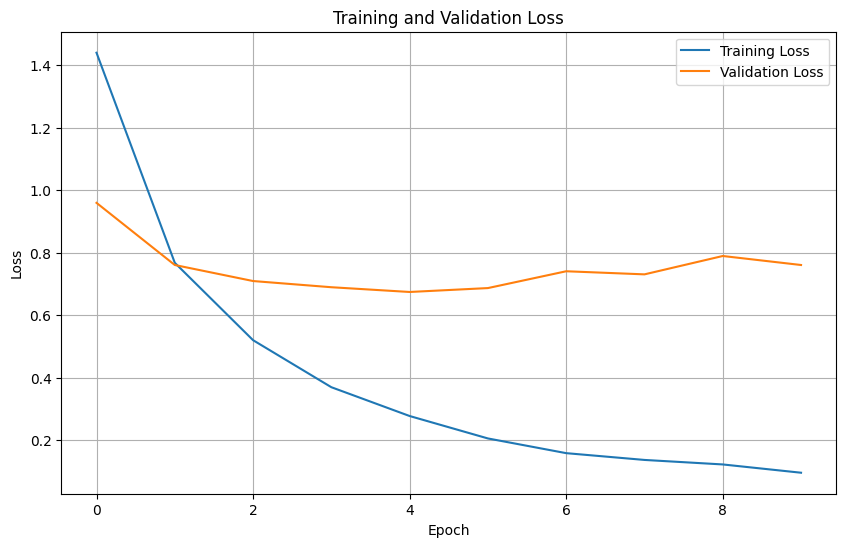

In [10]:
#Plotting training loss vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [11]:
#Function to plot the roc curve
def plot_roc_curve(model, test_loader, num_classes):
    model.eval()
    all_pred = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            pred = torch.softmax(outputs, dim=1)
            all_pred.append(pred.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_pred = np.concatenate(all_pred, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Compute ROC curve and ROC AUC for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((all_labels == i).astype(int), all_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

                       precision    recall  f1-score   support

               Access       0.90      0.82      0.86       174
Administrative rights       0.94      0.65      0.77        26
           HR Support       0.76      0.86      0.81       212
             Hardware       0.72      0.75      0.74       208
     Internal Project       0.81      0.88      0.84        48
        Miscellaneous       0.74      0.73      0.74       166
             Purchase       0.97      0.84      0.90        81
              Storage       0.90      0.84      0.87        85

             accuracy                           0.80      1000
            macro avg       0.84      0.80      0.81      1000
         weighted avg       0.81      0.80      0.80      1000



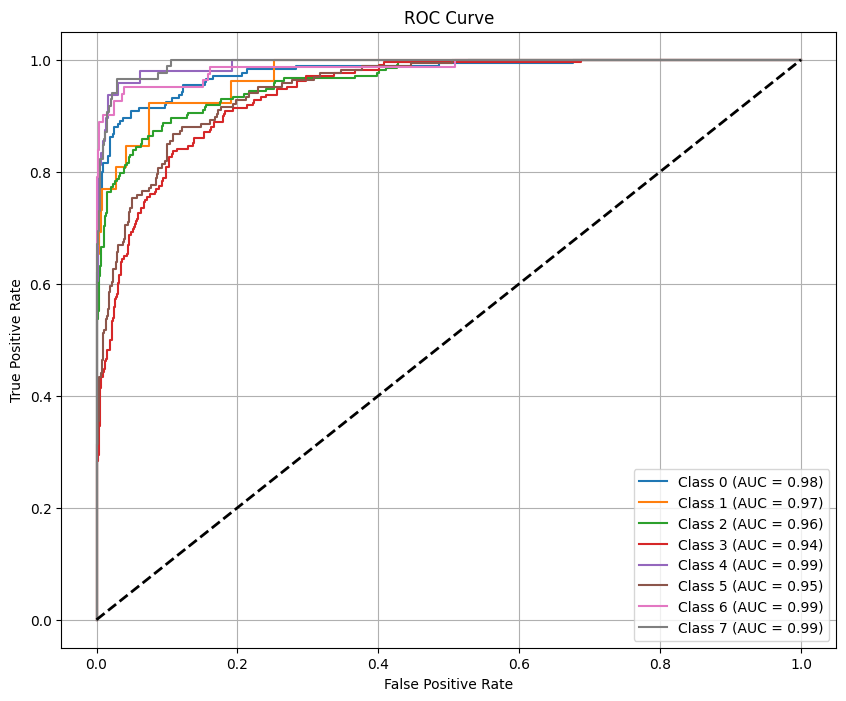

In [12]:
#Evaluation the model performance
preds, true_labels = evaluate_model(model, test_loader)

#Printing the classification report
print(classification_report(true_labels, preds, target_names=label_encoder.classes_))

# Ploting the ROC Curve
plot_roc_curve(model, test_loader, num_of_classes)

**Hyperparameter tuninng**

In [13]:
#Defining model v2
class TextCNN_V2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(TextCNN_V2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(embedding_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embedding_dim, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(embedding_dim, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 3, num_classes)
        self.dropout = nn.Dropout(0.8) #Increased the drop out

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x1 = torch.relu(self.bn1(self.conv1(x))).max(dim=2)[0]
        x2 = torch.relu(self.bn2(self.conv2(x))).max(dim=2)[0]
        x3 = torch.relu(self.bn3(self.conv3(x))).max(dim=2)[0]
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.dropout(x)
        return self.fc(x)


model_v2 = TextCNN_V2(len(word_to_index), embedding_dim, num_of_classes)
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=0.002, weight_decay=1e-6) #Increased learning rate and added regularization.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_v2.to(device)

# Training again with adjusted hyperparameters
train_losses_2, val_losses_2 = train_model(
    model_v2, train_loader, val_loader, criterion, optimizer_v2, num_epochs=10
)


100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Epoch 1/10, Train Loss: 2.8134, Val Loss: 1.2356


100%|██████████| 100/100 [00:34<00:00,  2.87it/s]


Epoch 2/10, Train Loss: 1.5781, Val Loss: 1.0755


100%|██████████| 100/100 [00:35<00:00,  2.85it/s]


Epoch 3/10, Train Loss: 1.3317, Val Loss: 0.9783


100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


Epoch 4/10, Train Loss: 1.1673, Val Loss: 0.8878


100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


Epoch 5/10, Train Loss: 1.0487, Val Loss: 0.7981


100%|██████████| 100/100 [00:33<00:00,  3.03it/s]


Epoch 6/10, Train Loss: 0.9638, Val Loss: 0.7492


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


Epoch 7/10, Train Loss: 0.8048, Val Loss: 0.7047


100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Epoch 8/10, Train Loss: 0.7538, Val Loss: 0.6787


100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


Epoch 9/10, Train Loss: 0.6825, Val Loss: 0.6600


100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


Epoch 10/10, Train Loss: 0.6237, Val Loss: 0.6599


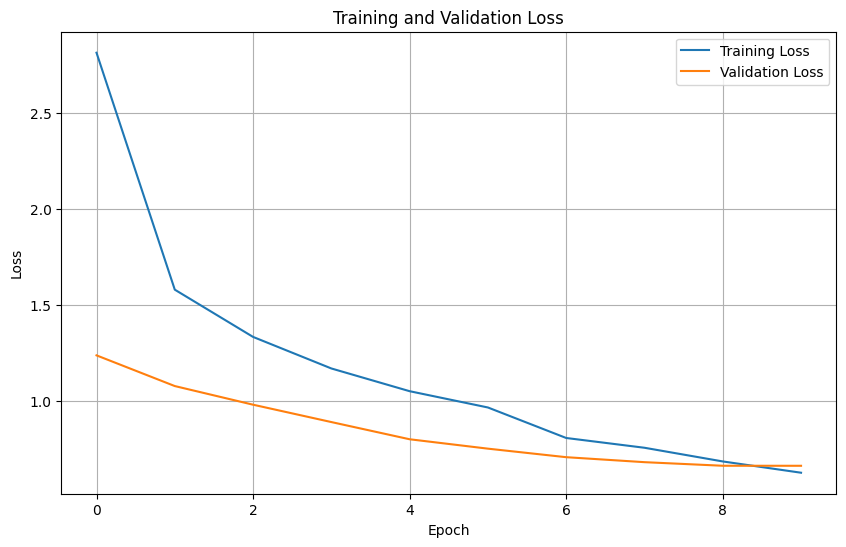

In [14]:
#Plotting training loss vs validation loss curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses_2, label="Training Loss")
plt.plot(val_losses_2, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

                       precision    recall  f1-score   support

               Access       0.89      0.86      0.88       174
Administrative rights       0.83      0.58      0.68        26
           HR Support       0.79      0.88      0.83       212
             Hardware       0.70      0.77      0.73       208
     Internal Project       0.89      0.81      0.85        48
        Miscellaneous       0.78      0.78      0.78       166
             Purchase       0.97      0.86      0.92        81
              Storage       0.97      0.76      0.86        85

             accuracy                           0.81      1000
            macro avg       0.85      0.79      0.82      1000
         weighted avg       0.82      0.81      0.82      1000



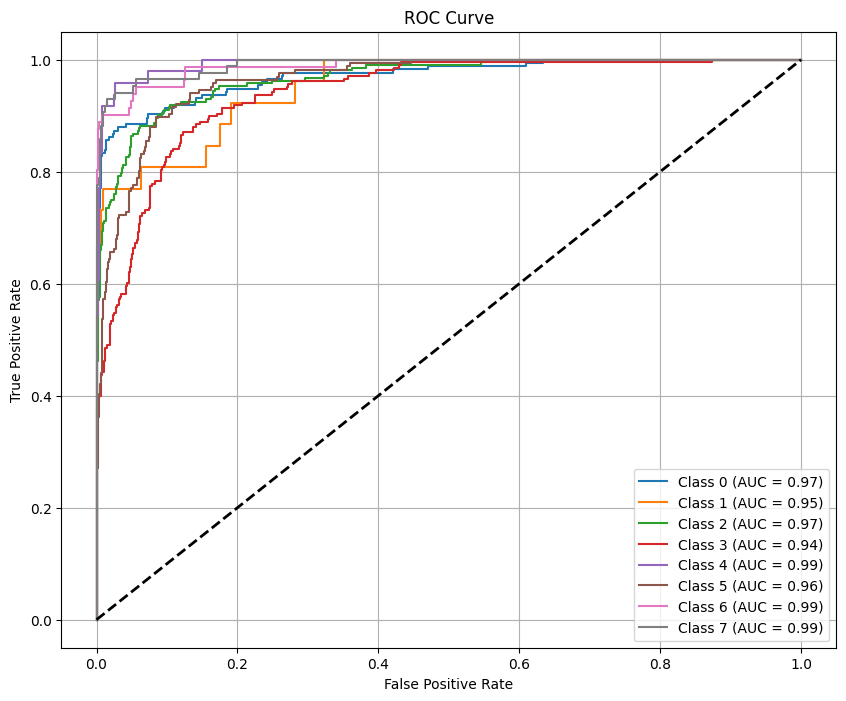

In [15]:
# Evaluating model performance
preds, true_labels = evaluate_model(model_v2, test_loader)

print(classification_report(true_labels, preds, target_names=label_encoder.classes_))

plot_roc_curve(model_v2, test_loader, num_of_classes)


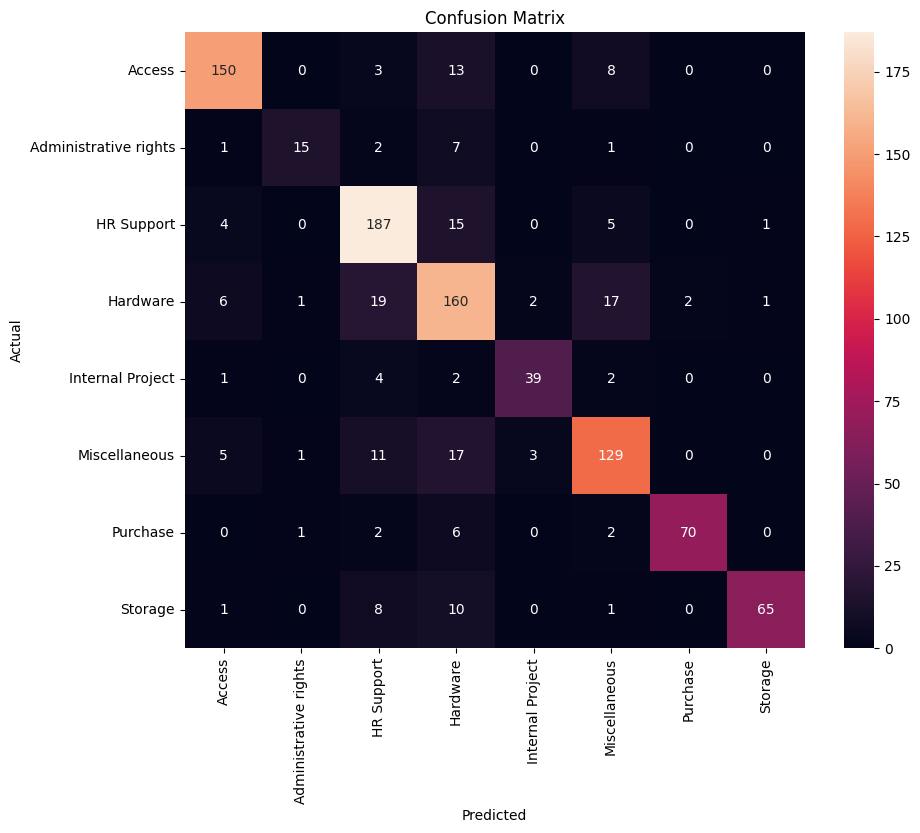

In [16]:
#Plotting the confusion matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()